In [2]:
# testing pyconturb
import matplotlib.pyplot as plt  # matplotlib for some plotting
import numpy as np  # numeric python functions
import pandas as pd  # need this to load our data from the csv files
import itertools
from scipy import interpolate

from pyconturb import gen_turb, gen_spat_grid, TimeConstraint  # generate turbulence, useful helper
from pyconturb.sig_models import iec_sig  # IEC 61400-1 turbulence std dev
from pyconturb.spectral_models import kaimal_spectrum  # Kaimal spectrum
from pyconturb.wind_profiles import constant_profile, power_profile  # wind-speed profile functions

from _nb_utils import plot_slice
import h5py

In [91]:
def find_best_fit_loglaw(u_target, z_target, kappa=0.4, d0=0.0):
    # assumes daytime conditions (psi is negative)

    u_star_values = np.linspace(0.4, 0.5, 5)
    z0_values = np.linspace(0.04, 0.06, 6) # np.logspace(-2, -1, 20) # np.logspace(-3, -1, 30) #[0.03] # np.logspace(-3, -1, 30)
    stab_values = np.linspace(-6, -4, 6) # np.linspace(-1, 0.5, 20) #np.linspace(-2, 1, 30)

    results = []

    for u_star, z0, stab in itertools.product(u_star_values, z0_values, stab_values):
    # for z0 in itertools.product(z0_values):
        if z_target <= d0 or z0 <= 0:
            continue

        u_calc1 = (u_star / kappa) * (np.log((z_target - d0) / z0) - stab)

        # first select based on error at first height
        if np.isclose(u_calc1, u_target, rtol=0.01):
            # calculate error
            error = np.abs(u_calc1 - u_target)
            results.append((u_star, z0, stab, u_calc1, error))

    df_results = pd.DataFrame(results, columns=['u_star', 'z0', 'psi', 'u_calc1', 'abs_error'])

    print(f"Found {len(df_results)} best-fit parameter sets")

    # select the params with the smallest absolute error
    sel_params = df_results.loc[df_results['abs_error'].idxmin()]

    return sel_params

def find_u_ref(z, z_hub, u_star, z0, psi, kappa=0.4, d0=0.0):
    # create function for funding u_ref at z_hub = 10 according to log law at flatirons
    u = (u_star / kappa) * (np.log((z - d0) / z0) - psi)
    
    # z_log = np.linspace(0.1, 10, 20)
    # u_log = (0.5/0.4)*np.log(z_log/0.05)+4.5 # to match M2 tower data
    # u_log = (0.55/0.4)*np.log(z_log/0.05)+4.5 # to match sonic data
    # u_log = (0.6/0.4)*np.log(z_log/0.05)+5.5 # to match sonic data
    f = interpolate.interp1d(z, u)

    u_ref = f(z_hub)

    return u_ref.item()

In [2]:
# sonic position
x_sonic1 = 0.0
y_sonic1 = 0.0
z_sonic1 = 2.23 # m above ground

sonic_spat_df = gen_spat_grid(y_sonic1, z_sonic1)  # if `comps` not passed in, assumes all 3 components are wanted
sonic_spat_df.head()  # look at the first few rows

,u_p0,v_p0,w_p0
k,0.00,1.00,2.00
x,0.00,0.00,0.00
y,0.00,0.00,0.00
z,2.23,2.23,2.23


In [3]:
# def read_csv_data(sonic_data_fn, dt_sonic1):
def read_csv_data(raw_data):
    # read csv
    # raw_data = pd.read_csv(sonic_data_fn, header=None)

    # select only sonic data columns
    sonic_data = raw_data[['u (m/s)', 'v (m/s)', 'w (m/s)']]

    # downsample from 50 Hz to 4 Hz (sonic resolution)
    # sonic_data = sonic_data.resample('250ms').median() # 4 Hz = 250 milliseconds

    # construct time index
    tmp = (sonic_data.index[1]-sonic_data.index[0])
    dt_sonic1 = round(tmp.total_seconds(), 3)
    # print(dt_sonic1)
    tf_sonic1 = len(sonic_data) * dt_sonic1 # final time [s]
    # print(tf_sonic1)
    t_sonic1 = np.arange(0.0, tf_sonic1, dt_sonic1)

    sonic_data = sonic_data.rename(columns={'u (m/s)':'u_p0', 'v (m/s)':'v_p0', 'w (m/s)':'w_p0'})
    for col in sonic_data.filter(regex='u_', axis=1).columns:
        sonic_data[col] = -1.0*sonic_data[col] # to make it positive from the west
    sonic_data['index'] = t_sonic1
    sonic_data = sonic_data.set_index('index')

    return tf_sonic1, sonic_data

# sonic_data_fn = 'sonic1_halfsecond_20Hz.csv'
# sonic_data_fn = 'sonic1_5s_20Hz.csv'
# sonic_data_fn = 'sonic1_20s_20Hz.csv'
# sonic_data_fn = 'sonic1_10min_20Hz.csv'
# sonic_data_fn = 'sonic1_10min_50Hz.csv'
sonic_data_fn = 'DuraMAT_tilt40deg_turbulent_inflow_10min_timeseries.csv'

raw_data = pd.read_csv(sonic_data_fn, index_col='Time')
raw_data.index = pd.to_datetime(raw_data.index)
# raw_data

# tmp = (raw_data.index[1]-raw_data.index[0])
# dt_sonic1 = round(tmp.total_seconds(), 3)

tf_sonic1, sonic_data = read_csv_data(raw_data)
dt = sonic_data.index[1]-sonic_data.index[0]
sonic_data

,u_p0,v_p0,w_p0
index,,,
0.00,9.541354,0.007880,0.718606
0.02,9.540954,0.008039,0.718082
0.04,9.540588,0.007120,0.718604
0.06,9.541167,0.005969,0.718446
0.08,9.541007,0.005632,0.718398
...,...,...,...
599.90,14.001130,2.163276,-0.917014
599.92,14.000917,2.163653,-0.916638
599.94,14.000855,2.163678,-0.916363


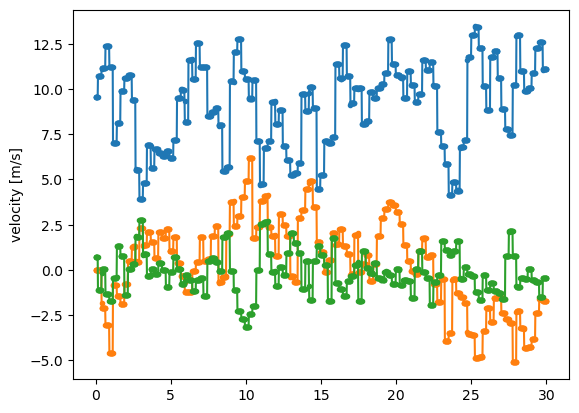

In [ ]:
# optional: cut down duration of signal for testing
tf_sonic1 = 10.0 # 30.0 # [s] - this is also how long the synthetic turbulence signal will be
sonic_data_trim = sonic_data.loc[sonic_data.index <= tf_sonic1]

fig, axs = plt.subplots()
for col in sonic_data_trim.columns:
    plt.plot(sonic_data_trim[col], marker='.', label=col)  # subselect long. wind component
    # plt.plot(sonic_data[col].resample('50L').first(), marker='.', label=col)  # subselect long. wind component
axs.set_ylabel('velocity [m/s]');

sonic_df_trim = pd.concat([sonic_spat_df, sonic_data_trim], axis=0)
# sonic_df.head()

In [222]:
gen_csv_fname = 'generated_{}_{}s_{}Hz.csv'.format(sonic_data_fn[:34],int(tf_sonic1),int(1/dt))
sonic_df_trim.to_csv(gen_csv_fname)

In [223]:
con_tc = TimeConstraint(pd.read_csv(gen_csv_fname, index_col=0))  # load data from csv directly into tc
# con_tc = TimeConstraint(pd.read_csv('generated_sonic1_1s.csv', index_col=0))  # load data from csv directly into tc
con_tc.index = con_tc.index.map(lambda x: float(x) if (x not in 'kxyz') else x)  # index cleaning
con_tc.iloc[:7, :]  # look at the first 7 rows

,u_p0,v_p0,w_p0
k,0.000000,1.000000,2.000000
x,0.000000,0.000000,0.000000
y,0.000000,0.000000,0.000000
z,2.230000,2.230000,2.230000
0.0,9.541354,0.007880,0.718606
0.02,9.540954,0.008039,0.718082
0.04,9.540588,0.007120,0.718604


In [224]:
time_df = con_tc.get_time()

u_mean_sonic1 = time_df.filter(regex='u_', axis=1).mean()
print(f'u_mean_sonic1 = {u_mean_sonic1.values[0]:.3f} m/s')

u_mean_sonic1 = 9.102 m/s


<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3124798/536766216.py:15: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(profile, z_values, label=f'u*={params['u_star']:.3f}, z0={params['z0']:.2e}, $\psi$={params['psi']:.2f}')


Found 11 best-fit parameter sets


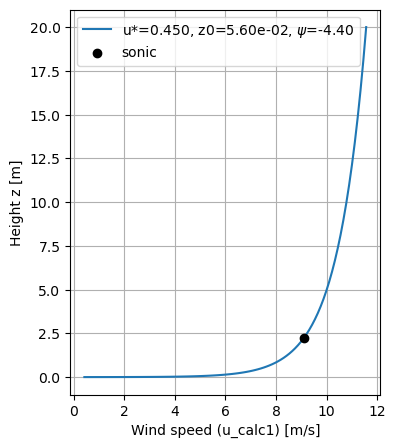

In [225]:
# find best-fit log law
kappa = 0.4
d0 = 0
z_max = 20.0

params = find_best_fit_loglaw(u_mean_sonic1.values[0], z_sonic1)

z_values = np.logspace(-3, np.log10(z_max), 100)

# Plot selected profile
plt.figure(figsize=(4,5))

# select the params with the smallest absolute error
profile = (params['u_star'] / kappa) * (np.log((z_values - d0) / params['z0']) - params['psi'])
plt.plot(profile, z_values, label=f'u*={params['u_star']:.3f}, z0={params['z0']:.2e}, $\psi$={params['psi']:.2f}')

plt.scatter(u_mean_sonic1.values[0], z_sonic1, color='k', label='sonic', zorder = 99)
# plt.scatter(m2['u'], m2['z'], color='k', marker='x', label='M2 tower data', zorder=100)

plt.xlabel('Wind speed (u_calc1) [m/s]')
plt.ylabel('Height z [m]')
plt.legend()
plt.grid(True)
# plt.xlim([8, 11])
# plt.ylim([2.0, 7.0])

plt.show()

In [ ]:

ny

58

dy = 0.714 m, dz = 0.29800 m


NameError: name 'con_tc' is not defined

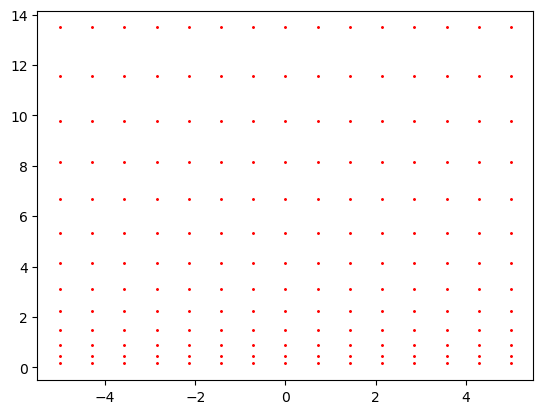

In [ ]:
# define spatial information

# to match pvade sim
y_min = -5.0
y_max = 5.0
# l_char = 0.17
# ny = int((y_max-y_min)/l_char)
ny = 20 #60 #130 # 300 # 130 #41
# nz = 60 #130 #20
y = np.linspace(y_min, y_max, ny) #11) #22)  # 11 lateral points from -50 to 50 (center @ 0)
# y = np.linspace(-10.0, 10.0, ny) #11) #22)  # 11 lateral points from -50 to 50 (center @ 0)
# y = np.linspace(-30.0, 30.0, ny) #11) #22)  # 11 lateral points from -50 to 50 (center @ 0)
# z = np.linspace(0.00001, 20.0, nz) #13) # 26)  # 13 vertical points from 40 to 160 (center @ 100)
# z = np.logspace(-5, 1.301, num=nz) #13) # 26)  # 13 vertical points from 40 to 160 (center @ 100)
# linearly increasing grid size in z
# steps = 0.15 + 0.02 * np.arange(60)
steps = 0.15 + 0.148 * np.arange(200)
z = 0.0001 + np.cumsum(steps)
z = z[z <= 15.0]
nz = len(z)

dy = y[1] - y[0] # (y[-1]-y[0])/ny
dz = z[1] - z[0] # (z[-1]-z[0])/nz

# this resolution should be approximately equal to or smaller than l_char
print(f'ny = {ny}, nz = {nz}')
print(f'dy = {dy:.3f} m, dz = {dz:.5f} m')

spat_df = gen_spat_grid(y, z)  # if `comps` not passed in, assumes all 3 components are wanted
spat_df.head()  # look at the first few rows

# visualization of simulation grid and constraining point(s)   
plt.scatter(spat_df.loc['y'], spat_df.loc['z'], color='r', s=0.5, label='sim. grid')
plt.plot(con_tc.iloc[2, :6], con_tc.iloc[3, :6], 'kX', label='sonic')
plt.xlabel('y [m]')
plt.ylabel('z [m]')
plt.axis('equal'); plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
# plt.xlim([-3, 3])
# plt.ylim([0, 5])

In [ ]:
# test z_hub of 10 vs sonic height (2.23?)
# fudge_factor = {}
# fudge_factor['2.23m'] = 2.1
# fudge_factor['10m'] = 1.75

# z_ref = {}
# z_ref['2.23m'] = z_sonic1
# z_ref['10m'] = 10.0

# u_ref = {}
# u_ref['2.23m'] = float(u_mean_sonic1.values[0])
# u_ref['10m'] = find_u_ref(z=z_values, z_hub=z_ref['10m'], u_star=params['u_star'], z0=params['z0'], 
#            psi=params['psi'], kappa=0.4, d0=0.0)

# sim_turb_df = {}
# for height in u_ref.keys():
#     u_ref_sim = u_ref[height] * fudge_factor[height]
#     print(f'simulating turb, u_ref = {u_ref_sim}, z_ref = {z_ref[height]}')
#     kwargs = {'u_ref': u_ref_sim, 'turb_class': 'B', 'z_hub': z_ref[height],  # necessary keyword arguments for IEC turbulence
#           'T': con_tc.get_T(), 'nt': con_tc.get_time().index.size}  # simulation length (s) and time step (s)
#     interp_data = 'none' # 'all'  # use the default IEC 61400-1 profile instead of interpolating from constraints
#     # generate turbulence
#     sim_turb_df[height] = gen_turb(spat_df, con_tc=con_tc, interp_data=interp_data, verbose=True, **kwargs)

simulating turb, u_ref = 19.11451904008661, z_ref = 2.23
Beginning turbulence simulation...
  Processing chunk 2 / 751
  Processing chunk 3 / 751
  Processing chunk 4 / 751
  Processing chunk 5 / 751
  Processing chunk 6 / 751
  Processing chunk 7 / 751
  Processing chunk 8 / 751
  Processing chunk 9 / 751
  Processing chunk 10 / 751
  Processing chunk 11 / 751
  Processing chunk 12 / 751
  Processing chunk 13 / 751
  Processing chunk 14 / 751
  Processing chunk 15 / 751
  Processing chunk 16 / 751
  Processing chunk 17 / 751
  Processing chunk 18 / 751
  Processing chunk 19 / 751
  Processing chunk 20 / 751
  Processing chunk 21 / 751
  Processing chunk 22 / 751
  Processing chunk 23 / 751
  Processing chunk 24 / 751
  Processing chunk 25 / 751
  Processing chunk 26 / 751
  Processing chunk 27 / 751
  Processing chunk 28 / 751
  Processing chunk 29 / 751
  Processing chunk 30 / 751
  Processing chunk 31 / 751
  Processing chunk 32 / 751
  Processing chunk 33 / 751
  Processing chunk 3

In [ ]:
# # reshape to 3D array
# data = {}
# for height in u_ref.keys():
#     data[height] = {}
#     data[height]['u'] = sim_turb_df[height].filter(regex='u').values.reshape(len(sim_turb_df[height]),y.size,z.size).transpose((0, 2, 1))
#     data[height]['v'] = sim_turb_df[height].filter(regex='v').values.reshape(len(sim_turb_df[height]),y.size,z.size).transpose((0, 2, 1))
#     data[height]['w'] = sim_turb_df[height].filter(regex='w').values.reshape(len(sim_turb_df[height]),y.size,z.size).transpose((0, 2, 1))

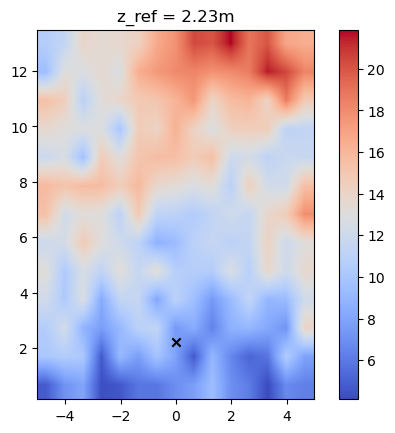

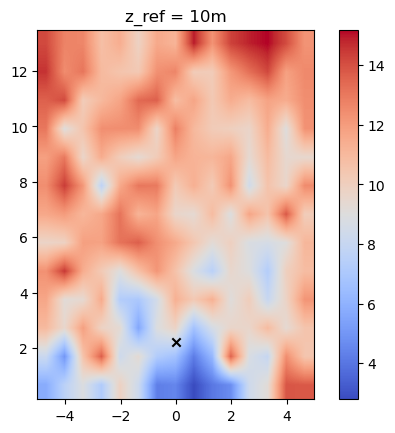

In [ ]:
# # check position
# for height in u_ref.keys():
#     fig, ax = plt.subplots()
#     plt.imshow(data[height]['u'][10,:,:],  # imshow requires nz-ny slice
#                 origin='lower',  # smallest y-z in lower left, not upper left
#                 extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
#                 interpolation='bilinear',
#                 cmap='coolwarm')  # image smoothing
#     plt.colorbar()
#     plt.scatter(y[j], z[k], c='k', marker='x')
#     plt.title(f'z_ref = {height}')

comparing timeseries at (y,z) = (0.00,2.23)
2.23m
measured mean wind speed =  8.848278555289422
simulated mean wind speed =  8.86940419033951
percent error = 0.24%
abs error = 0.04 m/s
10m
measured mean wind speed =  8.848278555289422
simulated mean wind speed =  8.720721225929994
percent error = -1.44%
abs error = 0.13 m/s


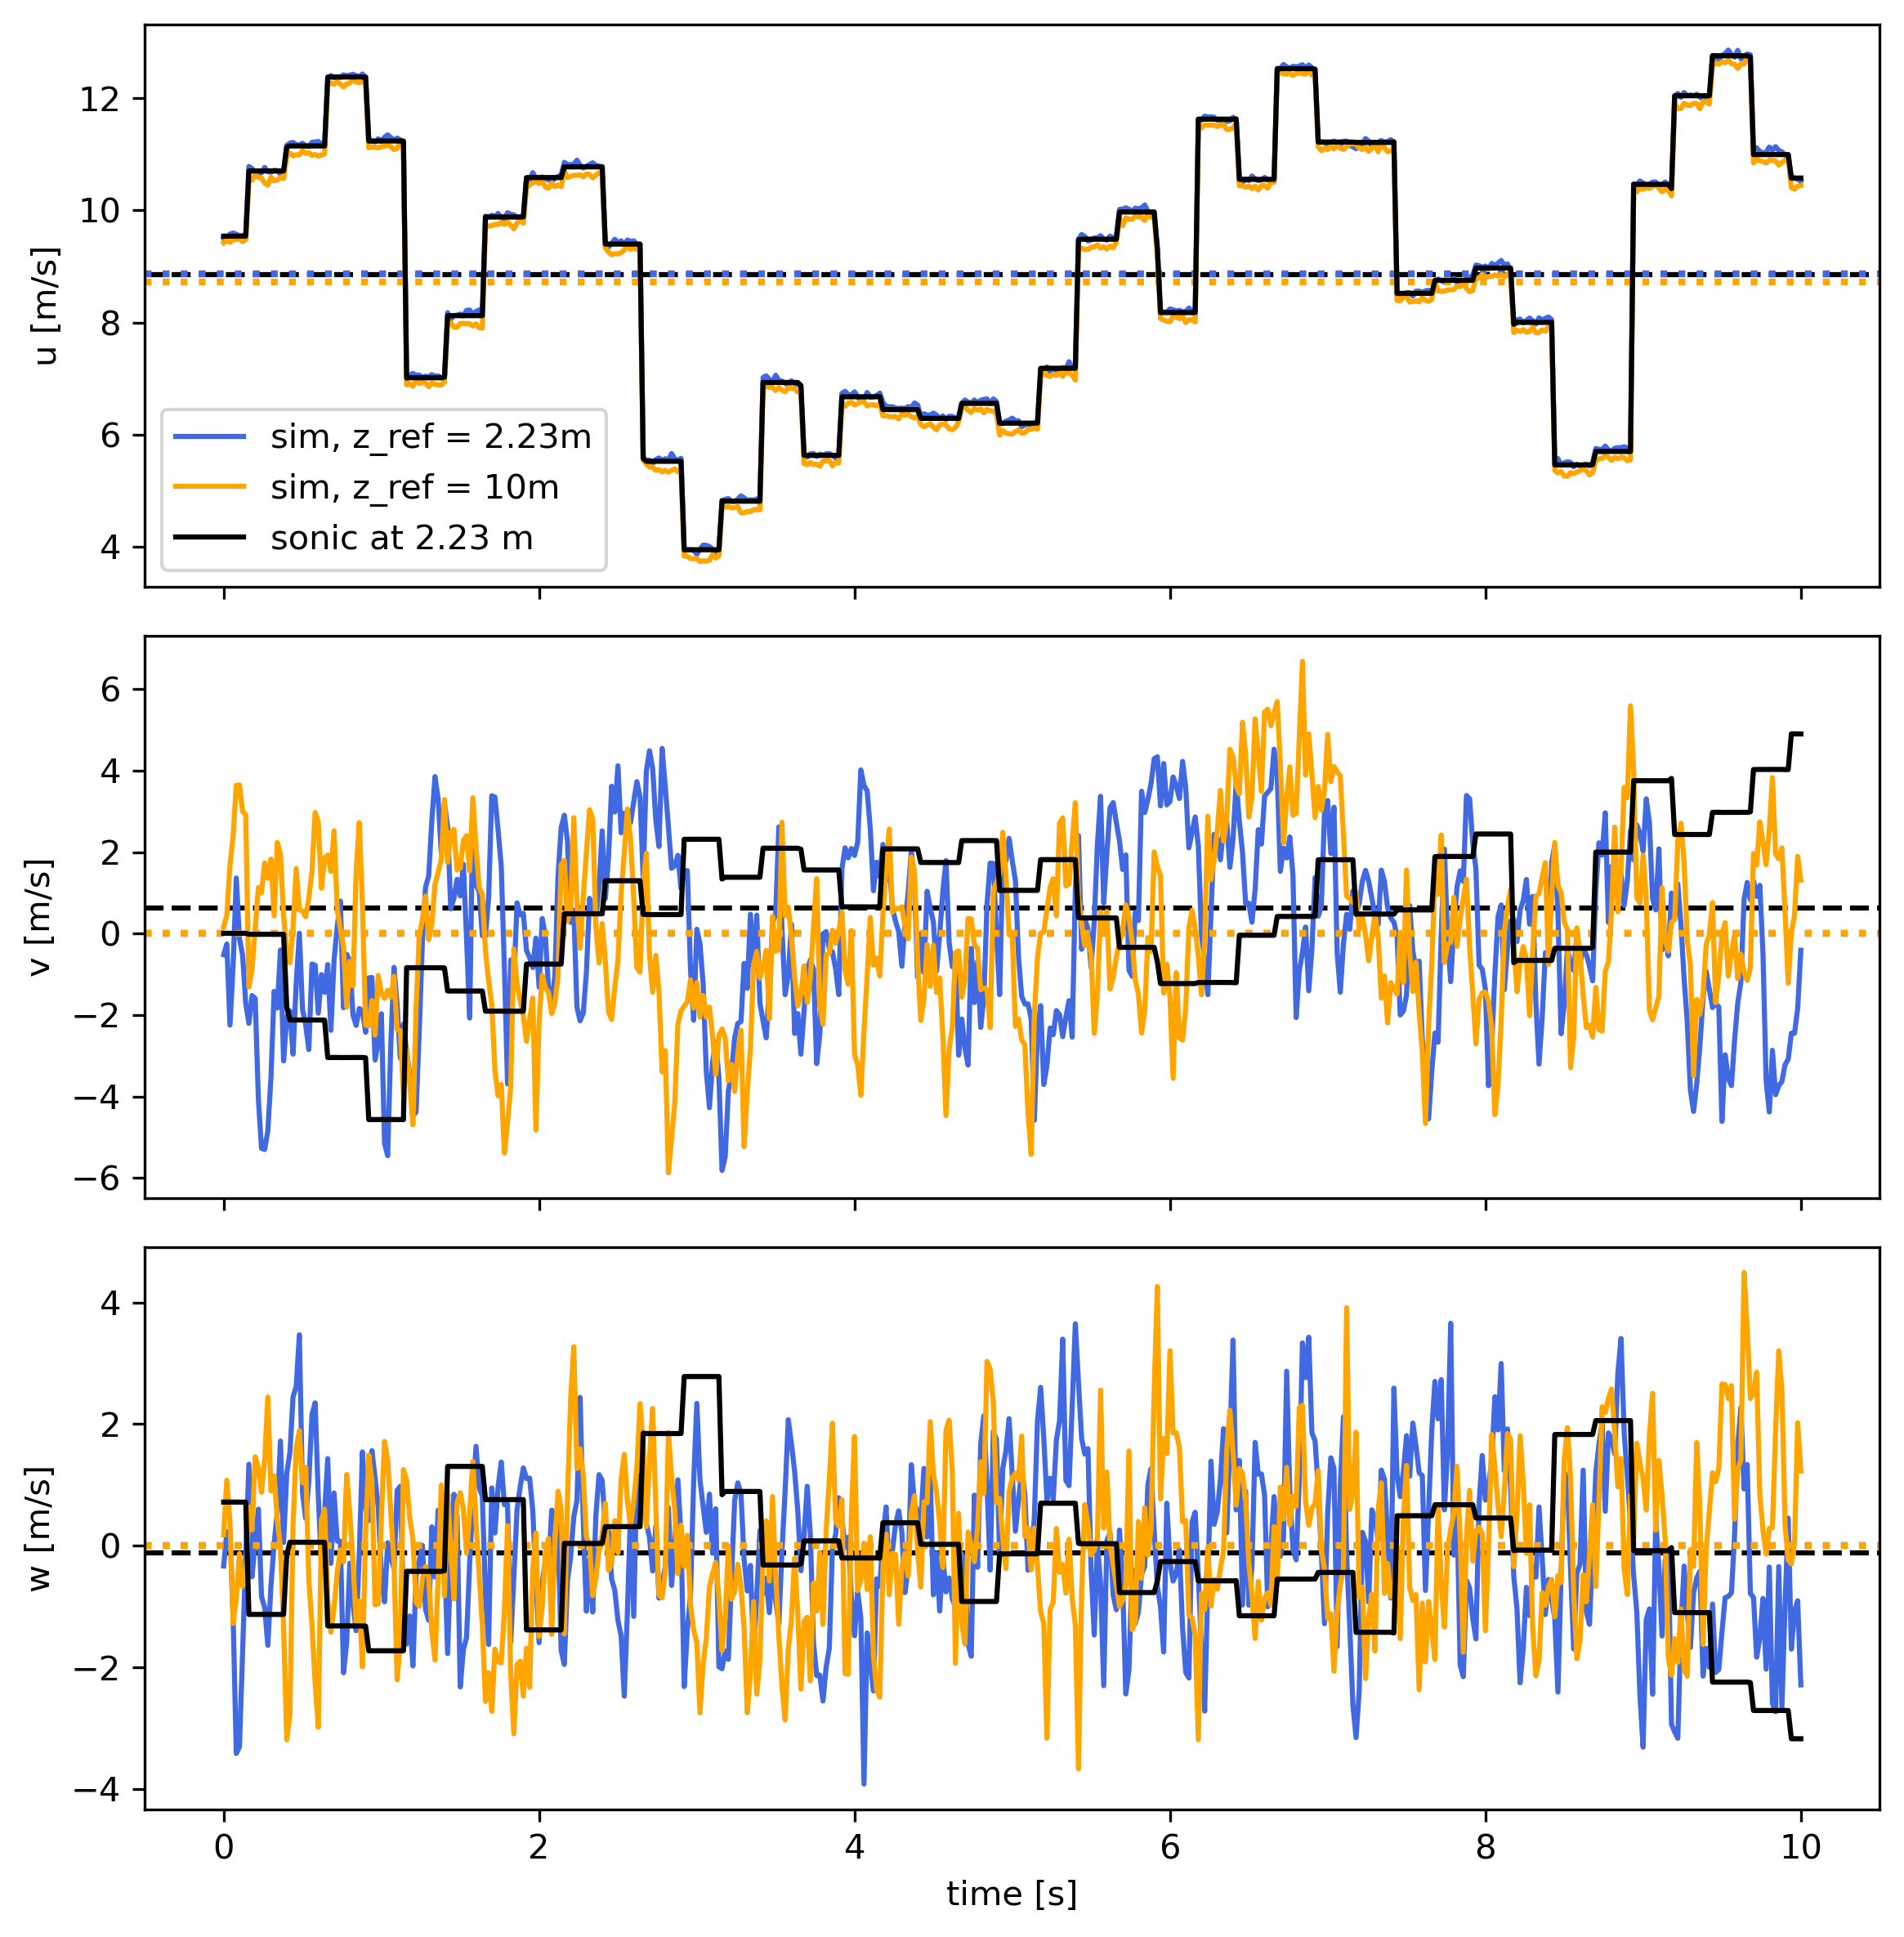

In [ ]:
# yloc = 0
# zloc = z_sonic1 # z_ref[height]  # location we want to compare

# j = np.argmin(abs(y - yloc))
# k = np.argmin(abs(z - zloc))#+1

# print('comparing timeseries at (y,z) = ({:.2f},{:.2f})'.format(y[j],z[k]))

# fig, axs = plt.subplots(3,1, figsize=[8,8], sharex=True, dpi=300)
# colors = {}
# colors['2.23m'] = 'royalblue'
# colors['10m'] = 'orange'

# for n,comp in enumerate(['u','v','w']):
#     ucon = con_tc.get_time()[comp+'_p0']
#     # ucon = sonic_data_trim[comp+'_p0']
    
#     for height in data.keys():
#         usim = data[height][comp][:,k,j]
        
#         t = sim_turb_df[height].index
#         axs[n].plot(t, usim, label=f'sim, z_ref = {height}', color=colors[height])
#         axs[n].axhline(np.average(usim), t[0], t[-1], linestyle=':', color=colors[height], linewidth=2.0)

#         if comp == 'u':
#             print(height)
#             measured_mean = np.average(ucon)
#             simulated_mean = np.average(usim)
#             print('measured mean wind speed = ', measured_mean)
#             print('simulated mean wind speed = ', simulated_mean)
#             print('percent error = {:.2f}%'.format(100*(simulated_mean - measured_mean) / measured_mean))
#             print('abs error = {:.2f} m/s'.format(np.average(abs(usim - ucon))))

#         axs[n].set_ylabel(comp+' [m/s]')
#     axs[n].plot(t, ucon, label=f'sonic at {z_sonic1} m', color='k')
#     axs[n].axhline(np.average(ucon), t[0], t[-1], linestyle='--', color='k', zorder=-10)
# axs[-1].set_xlabel('time [s]')   
# axs[0].legend();
# plt.tight_layout()

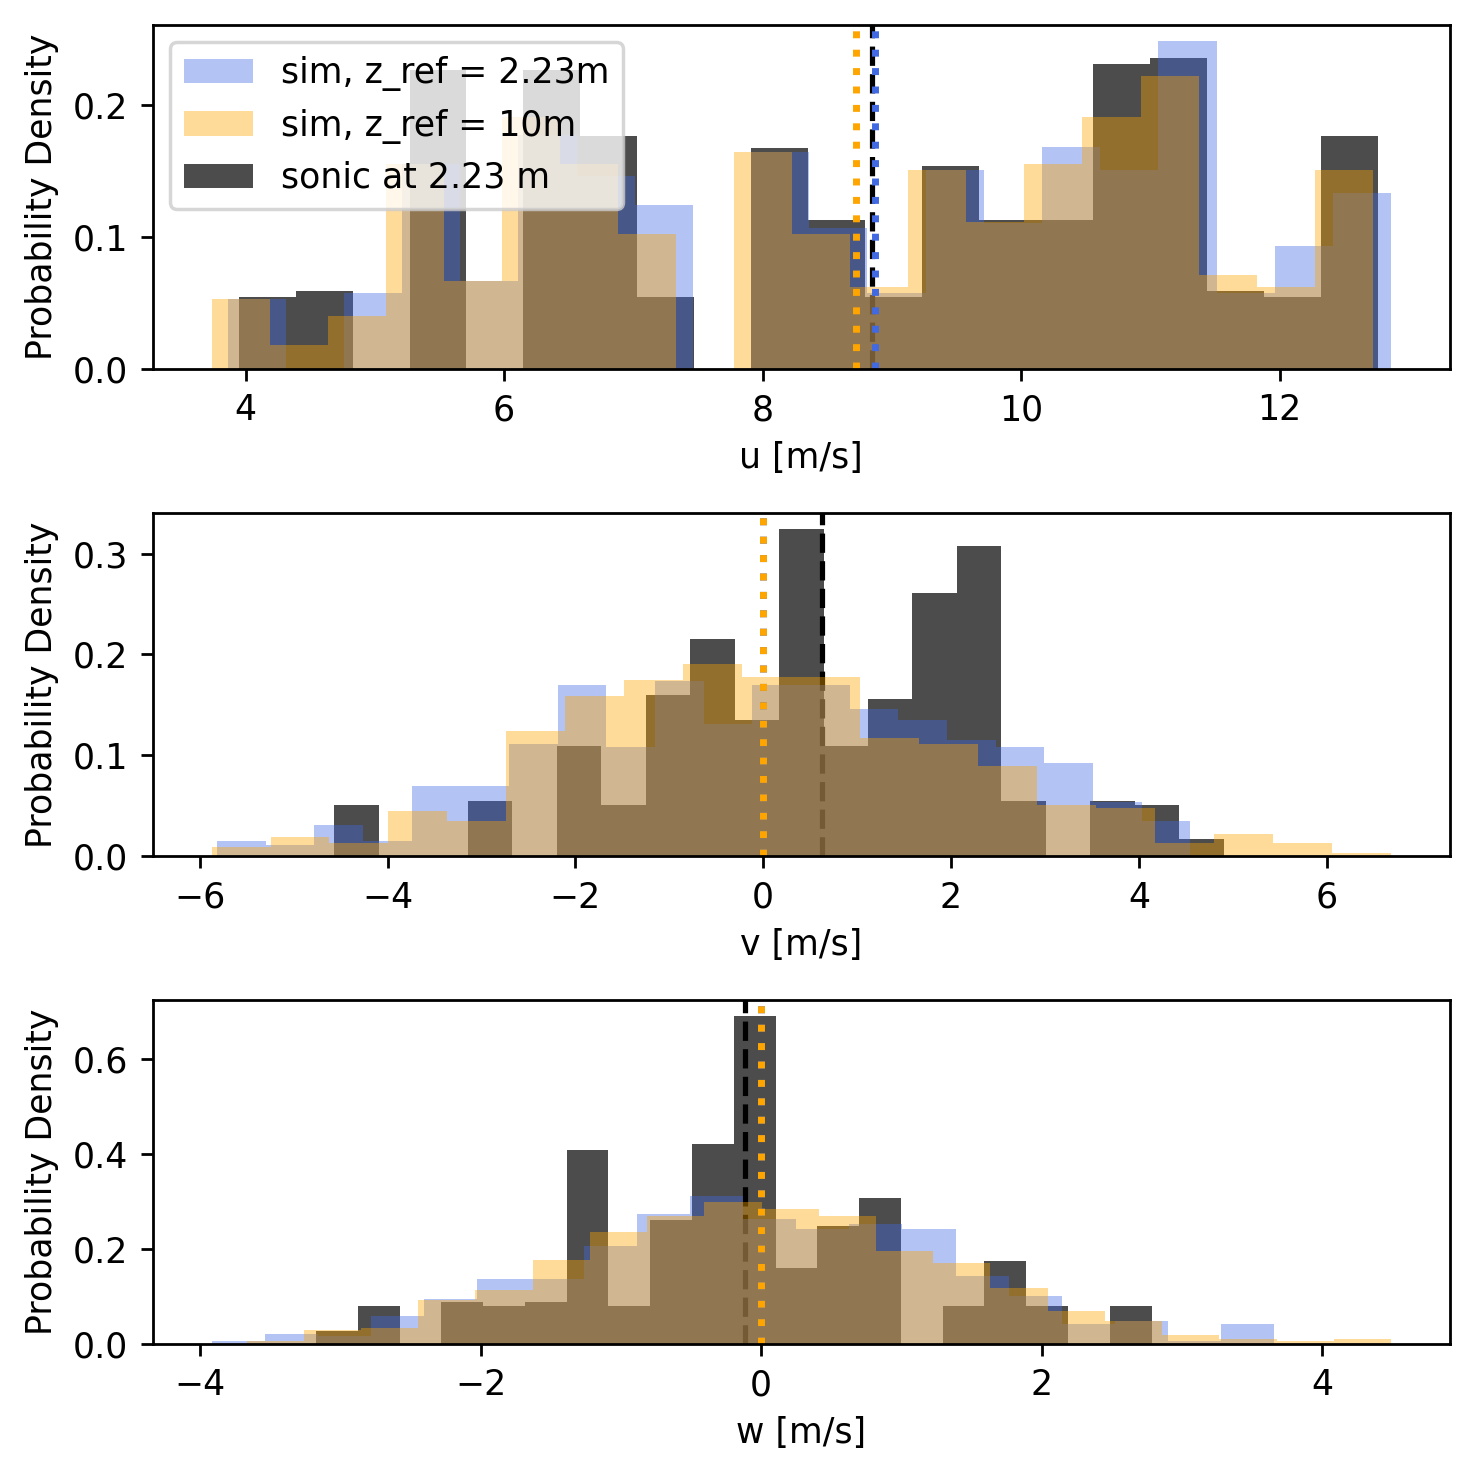

In [ ]:
# # histograms
# nbins = 20

# fig, axs = plt.subplots(3,1, figsize=[6,6], dpi=250)
# for n,comp in enumerate(['u','v','w']):
#     ucon = con_tc.get_time()[comp+'_p0']
    
#     for height in data.keys():
#         usim = data[height][comp][:,k,j]

#         axs[n].hist(usim, bins=nbins, density=True, color=colors[height], alpha=0.4, label=f'sim, z_ref = {height}')
# #         axs[n].plot(t, usim, label=f'sim, z_ref = {height}', color=colors[height])
#         axs[n].axvline(np.average(usim), linestyle=':', color=colors[height], linewidth=2.0)

# #         if comp == 'u':
# #             print(height)
# #             measured_mean = np.average(ucon)
# #             simulated_mean = np.average(usim)
# #             print('measured mean wind speed = ', measured_mean)
# #             print('simulated mean wind speed = ', simulated_mean)
# #             print('percent error = {:.2f}%'.format(100*(simulated_mean - measured_mean) / measured_mean))
# #             print('abs error = {:.2f} m/s'.format(np.average(abs(usim - ucon))))

#         axs[n].set_ylabel('Probability Density')
#         axs[n].set_xlabel(comp+' [m/s]')
#     axs[n].hist(ucon, bins=nbins, density=True, color='k', alpha=0.7, label=f'sonic at {z_sonic1} m', zorder=-10)
#     axs[n].axvline(np.average(ucon), linestyle='--', color='k', zorder=-9)
# # axs[-1].set_xlabel('time [s]')   
# axs[0].legend();
# plt.tight_layout()

In [ ]:
# test speed with nf_chunk np.float(32)
fudge_factor = 2.1
u_ref = float(u_mean_sonic1.values[0])
z_ref = z_sonic1

u_ref_sim = u_ref * fudge_factor
kwargs = {'u_ref': u_ref_sim, 'turb_class': 'B', 'z_hub': z_ref,  # necessary keyword arguments for IEC turbulence
      'T': con_tc.get_T(), 'nt': con_tc.get_time().index.size}  # simulation length (s) and time step (s)
interp_data = 'none' # 'all'  # use the default IEC 61400-1 profile instead of interpolating from constraints

# generate turbulence
sim_turb_df = gen_turb(spat_df, con_tc=con_tc, interp_data=interp_data, verbose=True, **kwargs)

NameError: name 'u_mean_sonic1' is not defined

In [ ]:
# test speed compared to local machine

In [ ]:
# testing for converting to .py script to launch on hpc